In [1]:
using StatsBase
using StatsAPI
using Distributions
using Plots

In [2]:
#plotlyjs()

## Summary

If we want to eliminate non-Poisson transitions in the model, we need to simplify (1) the age distribution (currently a truncated exponential) and (2) the liver stage distribution (currently a fixed point at 14 days).

To see if this is reasonable, I wrote a function to compute the parameters for an Erlang distribution—a gamma with an integral shape parameter, which can be simulated using repeated exponential draws—given a particular mean and standard deviation. The mean is matched exactly, and the shape parameter is chosen to match the standard deviation as closely as possible given the mean.

For the age distribution, an Erlang distribution is unrealistic because it is clamped to zero density at x = 0, while real age distributions have high infant mortality. I'd recommend just using a non-truncated exponential distribution—the tail is, after all, exponential! We can reduce the mean to match the current truncated distribution, at least to compare outputs. The standard deviation ends up being similar

For the liver stage, you can get a relatively narrow distribution using a shape parameter of 49, which means 49 extra transitions per infection, but these transitions should be relatively inexpensive given that exponential draws have now been sped up. We will check this empirically, of course, by measuring changes in performance.

## Functions to match an Erlang distribution to a given mean/SD 

In [3]:
"""
Find an Erlang distribution with the provided mean and a shape 
chosen to match the provided standard deviation as closely as possible.
"""
function erlang_params_with_mean_approxsd(mean, approxsd)
    best_shape_int = nothing
    best_sd_abs_diff = Inf
    for shape_int in 1:1000
        shape = Float64(shape_int)
        scale = mean / shape
        sd = scale * sqrt(shape)
        sd_abs_diff = abs(sd - approxsd)
        if sd_abs_diff < best_sd_abs_diff
            best_shape_int = shape_int
            best_sd_abs_diff = sd_abs_diff
        elseif sd_abs_diff > best_sd_abs_diff
            break
        end
    end
    (best_shape_int, mean / best_shape_int)
end

erlang_params_with_mean_approxsd

shape = 16, scale = 0.125
mean = 2.0, sd = 0.5


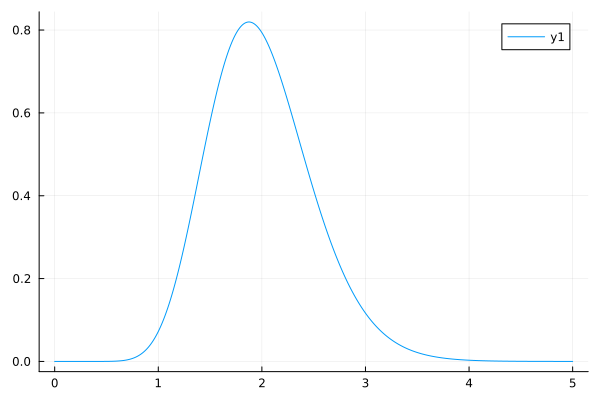

In [4]:
# Try it with mean of 2, sd of 0.5

begin
    shape_int, scale = erlang_params_with_mean_approxsd(2.0, 0.5)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.01:5.0
    plot(x, pdf(dist, x))
end

shape = 400, scale = 0.005
mean = 2.0, sd = 0.1


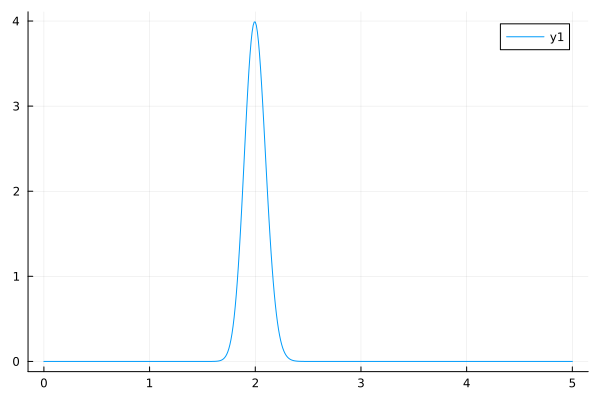

In [5]:
# Try it with mean of 2, sd of 0.1

begin
    shape_int, scale = erlang_params_with_mean_approxsd(2.0, 0.1)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.01:5.0
    plot(x, pdf(dist, x))
end

## Match age distribution with Erlang or non-truncated exponential

mean, sd after truncation = 24.47716156845296, 20.434207157123016
shape = 2, scale = 12.23858078422648
mean = 24.47716156845296, sd = 17.307966929251837


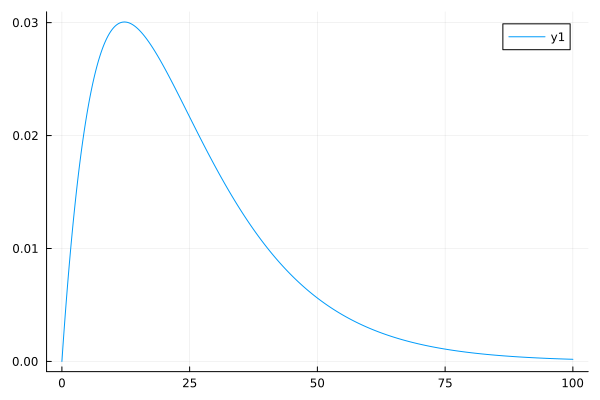

In [6]:
# Compute mean, sd of the age distribution currently used in the model

begin
    mean_age_before_truncation = 30.0
    max_age = 80.0

    dist = Exponential(30.0)
    function sample_truncated()
        while true
            x = rand(dist)
            if x < max_age
                return x
            end
        end
    end

    v = [sample_truncated() for i in 1:1000]
    mean_age_after_truncation = mean(v)
    sd_after_truncation = std(v)

    println("mean, sd after truncation = $(mean_age_after_truncation), $(sd_after_truncation)")

    # Match these with an Erlang distribution
    shape_int, scale = erlang_params_with_mean_approxsd(mean_age_after_truncation, sd_after_truncation)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.1:100.0
    plot(x, pdf(dist, x))
end

mean, sd after truncation = 24.021009279517465, 19.719858004709515
mean = 24.021009279517465, sd = 24.021009279517465


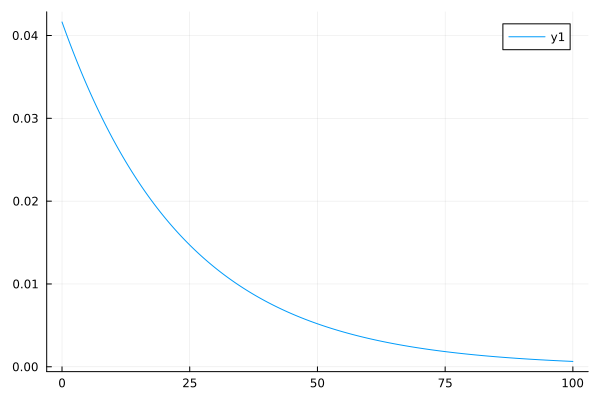

In [7]:
# What about just using an exponential distribution???

begin
    mean_age_before_truncation = 30.0
    max_age = 80.0

    dist = Exponential(30.0)
    function sample_truncated()
        while true
            x = rand(dist)
            if x < max_age
                return x
            end
        end
    end

    v = [sample_truncated() for i in 1:1000]
    mean_age_after_truncation = mean(v)
    sd_after_truncation = std(v)

    println("mean, sd after truncation = $(mean_age_after_truncation), $(sd_after_truncation)")

    # Just use an exponential distribution
    dist = Exponential(mean_age_after_truncation)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.1:100.0
    plot(x, pdf(dist, x))
end

(It's really quite close, with a longer tail of course, but a rather similar mean/std.)

## Make a liver stage distribution with a relatively small SD

shape = 49, scale = 0.2857142857142857
mean = 14.0, sd = 1.9999999999999998


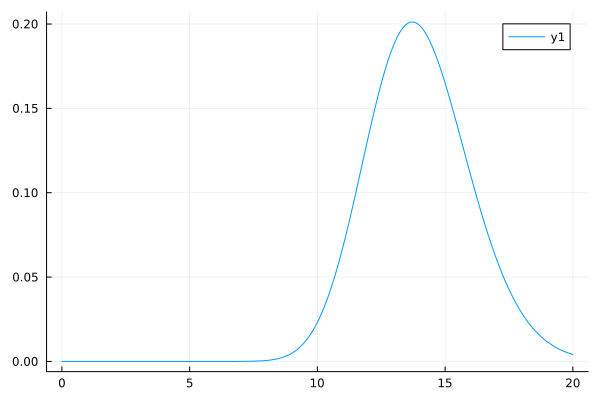

In [8]:
begin
    shape_int, scale = erlang_params_with_mean_approxsd(14.0, 2.0)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.01:20
    plot(x, pdf(dist, x))
end

This will slow things a bit due to 49 extra transitions, but with faster RNG should be pretty insignificant as no other computation is done. (Edit 4/1/24: actually slows things down significantly because of the extra events. shape parameter 25 seems OK after some optimizations.)

shape = 5, scale = 2.8
mean = 14.0, sd = 6.260990336999411


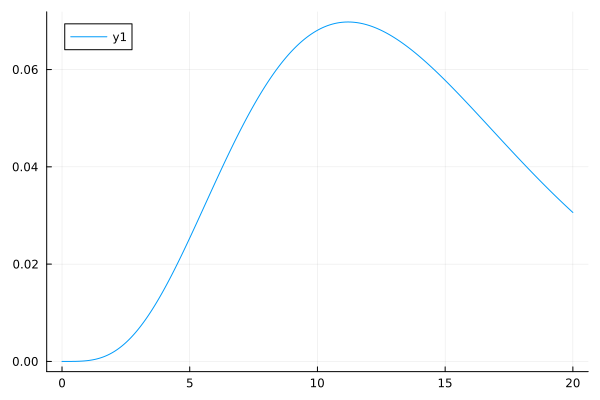

In [9]:
# And here's a less narrow one

begin
    shape_int, scale = erlang_params_with_mean_approxsd(14.0, 6.0)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.01:20
    plot(x, pdf(dist, x))
end

shape = 25, scale = 0.56
mean = 14.000000000000002, sd = 2.8000000000000003


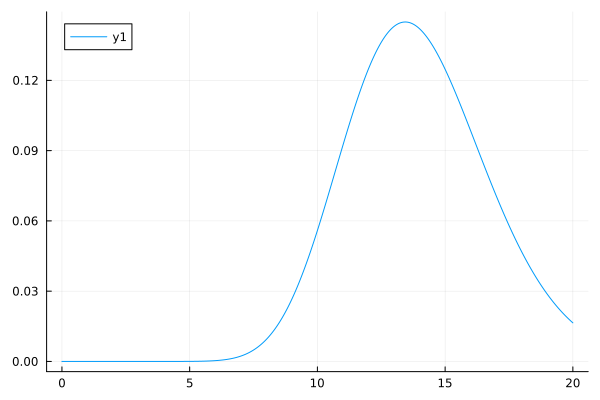

In [18]:
# And here's one w/ shape 25-ish

begin
    shape_int, scale = erlang_params_with_mean_approxsd(14.0, 2.8)
    println("shape = $(shape_int), scale = $(scale)")
    dist = Gamma(shape_int, scale)
    println("mean = $(mean(dist)), sd = $(std(dist))")
    x = 0.0:0.01:20
    plot(x, pdf(dist, x))
end